# Learn ResNET architecture from scratch with Pytorch

This is my first model ResNET architecture in Pytorch.

The link of the paper is :

https://arxiv.org/pdf/1512.03385.pdf

So we get the following picture of the architecture :



# With Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(ResidualBlock, self).__init__()
        
        self.expansion = 4
        
        self.conv1 = nn.Conv2d(in_channels
                              ,out_channels
                              ,kernel_size = (1, 1)
                              ,stride      = 1
                              ,padding     = 0
                              )
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels
                              ,out_channels
                              ,kernel_size = (3, 3)
                              ,stride      = stride
                              ,padding     = 1
                              )
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels
                              ,out_channels * self.expansion
                              ,kernel_size = (1, 1)
                              ,stride      = 1
                              ,padding     = 0
                              )
        
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU()
        
        self.identity_downsample = identity_downsample
        
        self.stride = stride
        
    def forward(self, input):
        
        identity = input

        conv_1 = self.conv1(input)
        bn_1 = self.bn1(conv_1)
        relu_1 = self.relu(bn_1)
        
        conv_2 = self.conv2(relu_1)
        bn_2 = self.bn2(conv_2)
        relu_2 = self.relu(bn_2)
        
        conv_3 = self.conv3(relu_2)
        x = self.bn3(conv_3)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        
        out = self.relu(x)
        
        return out

In [3]:
class ResNet(nn.Module):
    
    # layers is a list and is the number of time the ResidualBlock is used. 
    # Exemple for 50-layers we have in the table [3, 4, 6, 3]
    
    # image_chanels is the number of channels in the input in RGB we have 3 input channels.
    
    def __init__(self, ResidualBlock, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(ResidualBlock, layers[0], out_channels = 64 , stride = 1)
        self.layer2 = self._make_layer(ResidualBlock, layers[1], out_channels = 128, stride = 2)
        self.layer3 = self._make_layer(ResidualBlock, layers[2], out_channels = 256, stride = 2)
        self.layer4 = self._make_layer(ResidualBlock, layers[3], out_channels = 512, stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * 4, num_classes)
    
    def forward(self, input):
        
        conv_1 = self.conv1(input)
        bn_1   = self.bn1(conv_1)
        x      = self.relu(bn_1)
        
        x = self.maxpool(x)
        
        layer_1 = self.layer1(x)
        layer_2 = self.layer2(layer_1)
        layer_3 = self.layer3(layer_2)
        layer_4 = self.layer4(layer_3)

        x = self.avgpool(layer_4)
        x = x.reshape(x.shape[0], -1)
        
        out = self.fc(x)

        return out
        
    def _make_layer(self, ResidualBlock, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels
                                                         ,out_channels * 4
                                                         ,kernel_size = 1
                                                         ,stride      = stride
                                                         ),
                                                nn.BatchNorm2d(out_channels * 4)
                                               )
        
        layers.append(ResidualBlock(self.in_channels
                                   ,out_channels
                                   ,identity_downsample
                                   ,stride
                                   )
                     )
        
        self.in_channels = out_channels * 4
        
        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        
        for i in range(num_residual_blocks - 1):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)

In [4]:
def ResNet50(img_channel, num_classes = 10):
    layers = [3, 4, 6, 3]
    return ResNet(ResidualBlock, layers, img_channel, num_classes)

def ResNet101(img_channel, num_classes = 10):
    layers = [3, 4, 23, 3]
    return ResNet(ResidualBlock, layers, img_channel, num_classes)

def ResNet152(img_channel, num_classes = 10):
    layers = [3, 8, 36, 3]
    return ResNet(ResidualBlock, layers, img_channel, num_classes)

In [5]:
from torchsummary import summary

model = ResNet50(img_channel = 3, num_classes = 5)
summary(model.cuda(), input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

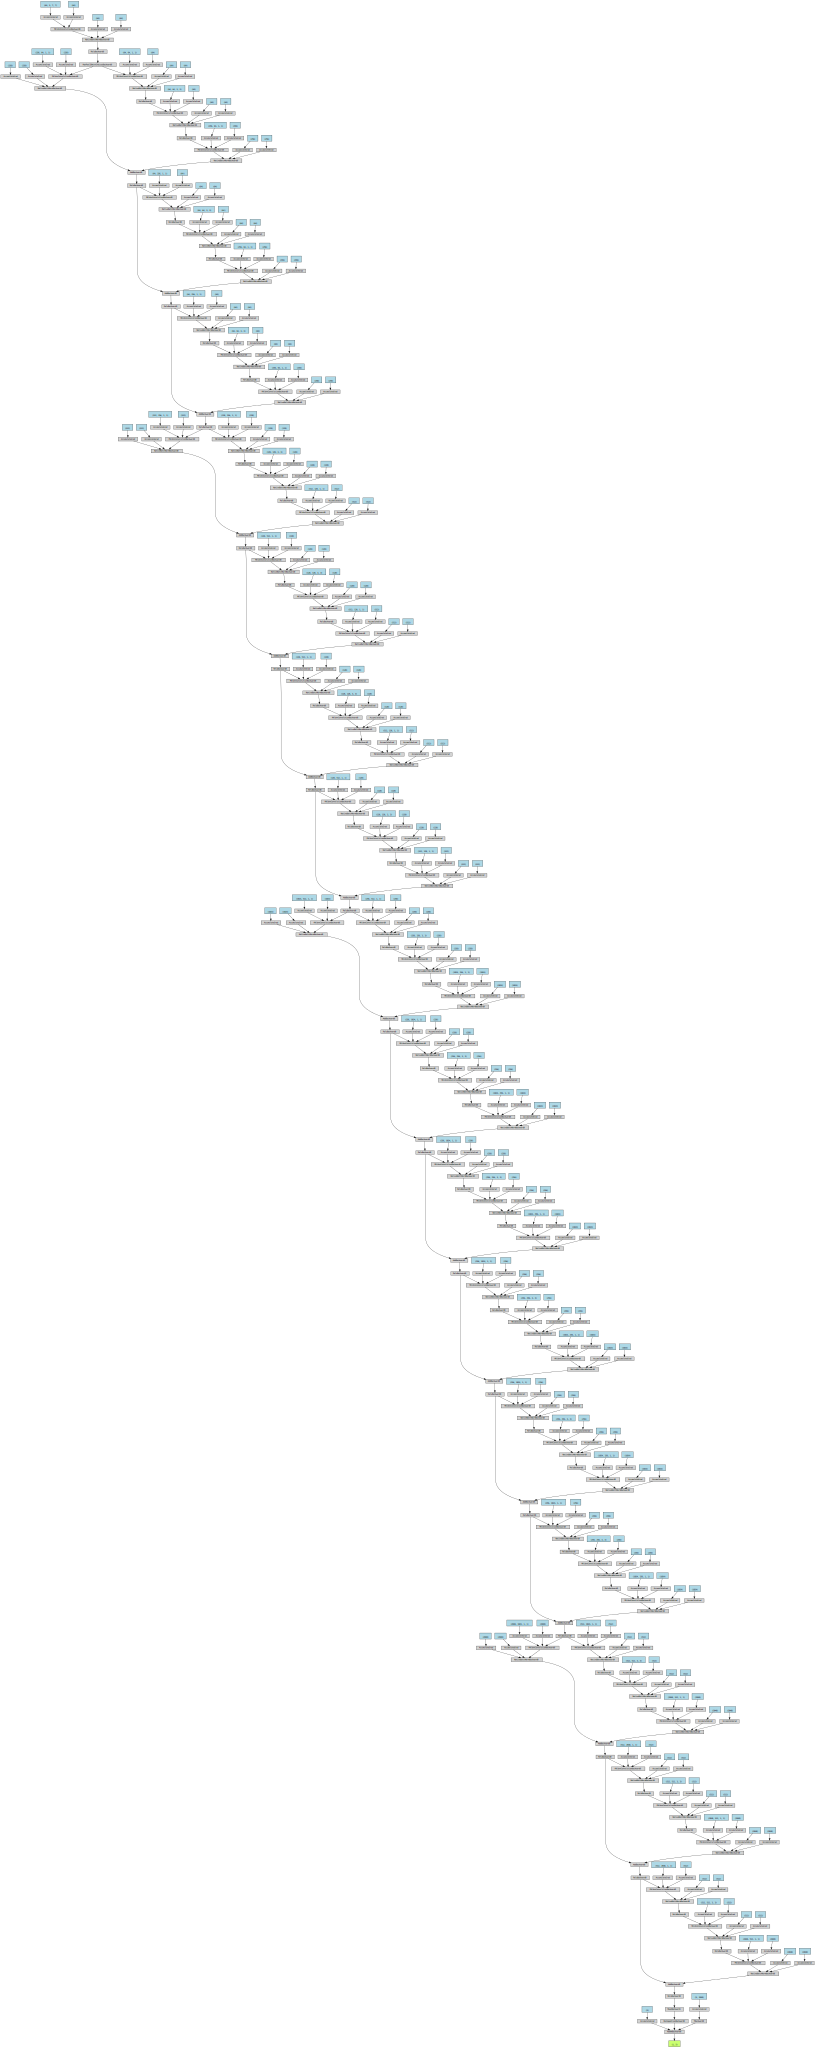

In [6]:
from torchviz import make_dot

x = torch.randn(1, 3, 224, 224)

model_1_cpu = ResNet50(img_channel = 3, num_classes = 5)
model_1_cpu_out = model_1_cpu(x)

#g = make_dot(out, params=None)
#g.view()
make_dot(model_1_cpu_out, params = None)

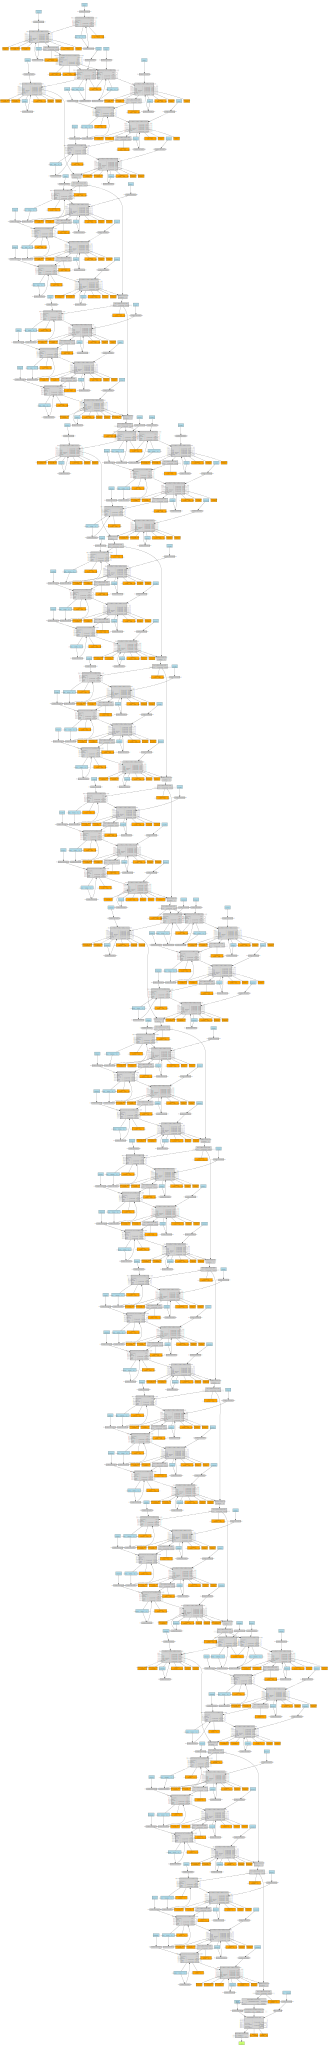

In [7]:
make_dot(model_1_cpu_out.mean(), params = None, show_attrs = True, show_saved = True)